<a href="https://colab.research.google.com/github/DesiPilla/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

Group members:
 * Olivia Mwangi
 * Desiderio Pilla
 * Akshaya Ramesh

# Import packages

In [0]:
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
!pip install tweepy

In [3]:
import tweepy
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from string import punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
from joblib import dump, load
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Utility functions

In [0]:
def print_balance(df, col='senti'):
    counts = df[col].value_counts(normalize=True)
    print('This dataset contains {0} negative tweets ({1:.1%})'.format(int(counts[0]*len(df)), counts[0]))
    print('This dataset contains {0} neutral tweets ({1:.1%})'.format(int(counts[2]*len(df)), counts[2]))
    print('This dataset contains {0} positive tweets ({1:.1%})'.format(int(counts[4]*len(df)), counts[4]))
    return counts

def clean_sentiment(s):
    '''
    This function cleans the sentiment label for tweets in the Sanders Analytics dataset.
    
    Inputs: string (sentiment label : {'negative', 'neutral', 'positive'})
    Outputs: integer (sentiment label : {0, 2, 4})
    '''
    if s == 'positive':
        return 4
    elif s == 'negative':
        return 0
    else:
        return 2

def preprocessTweets(text):

    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    
    return text


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=SVC()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

# Get Training Data

For our training data, we will use two datasets.

The first dataset we will use comes from GitHub user [TharinduMunasinge](https://github.com/TharinduMunasinge/Twitter-Sentiment-Analysis/tree/master/DataSet). This dataset contains 997 tweets that have a pre-labeled sentiment:
 * 0 = negative
 * 2 = neutral
 * 4 = positive

In [6]:
data1 = pd.read_csv('https://github.com/TharinduMunasinge/Twitter-Sentiment-Analysis/raw/master/DataSet/FinalizedFull.csv').rename(columns={'tweet':'text'})
data1.head()

,text,senti
0,@united UA5396 can wait for me. I'm on the gro...,0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0
2,"@united Oh, we are sure it's not planned, but ...",0
3,Tom Shanahan's latest column on SDSU and its N...,2
4,Found the self driving car!! /IWo3QSvdu2,2


In [7]:
# Check the balance of the dataset
counts1 = print_balance(data1)

This dataset contains 377 negative tweets (37.8%)
This dataset contains 239 neutral tweets (24.0%)
This dataset contains 381 positive tweets (38.2%)


As we can see, this dataset is not balanced. More tweets are labeled positive or negative than neutral. While this may be representative of all tweets, we may need to consider this so as to not bias our model. However, this dataset contains relatively few observations, so we will combine it with another dataset of labeled tweets as well.

The [second dataset](https://github.com/zfz/twitter_corpus) we will use in our training set comes from the twitter sentiment corpus created by Sanders Analytics. This dataset consists of 3424 relevant hand-classified tweets. Irrelevant observations in this dataset include Spanish content. For this project, we will restrict our model to only classify English tweets.

In [8]:
# Read in the dataset
data2 = pd.read_csv('https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv')[['Sentiment', 'TweetText']].rename(columns={'Sentiment':'senti', 'TweetText':'text'})

# Drop all spanish observations
data2 = data2[data2.senti != 'irrelevant']

# Clean the sentiment labels
data2['senti'] = data2['senti'].apply(clean_sentiment)

data2.head()

,senti,text
0,4,Now all @Apple has to do is get swype on the i...
1,4,@Apple will be adding more carrier support to ...
2,4,Hilarious @youtube video - guy does a duet wit...
3,4,@RIM you made it too easy for me to switch to ...
4,4,I just realized that the reason I got into twi...


In [9]:
# Check the balance of the dataset
counts2 = print_balance(data2)

This dataset contains 572 negative tweets (16.7%)
This dataset contains 2333 neutral tweets (68.1%)
This dataset contains 519 positive tweets (15.2%)


Unlike the first dataset, this corpus contains significantly more neutral tweets than it does positive/negative tweets. According to literature, **[INCLUDE INFORMATION ABOUT WHAT THE SENTIMENT DISTRIBUTION IS SUPPOSED TO BE]**.

In [10]:
# Concatenate both training sets
train = pd.concat([data1, data2])

# Check the balance of the dataset
train_counts = print_balance(train)

This dataset contains 949 negative tweets (21.5%)
This dataset contains 2572 neutral tweets (58.2%)
This dataset contains 900 positive tweets (20.4%)


However, to ensure our model does not overfit to certain sentiments, we will balance our training data to include nearly equal counts of each sentiment classification.

In [11]:
# Get the smallest number of observations for a sentiment label
minNum = int(train_counts.min() * len(train))

# Split the observations by sentiment and keep the same number of observations for each
train_neg = train[train.senti == 0].iloc[:minNum, :]
train_neu = train[train.senti == 2].iloc[:minNum, :]
train_pos = train[train.senti == 4].iloc[:minNum, :]

# Combine observations back into one dataframe 
train_bal = pd.concat([train_neg, train_neu, train_pos])
train_bal_counts = print_balance(train_bal)

This dataset contains 900 negative tweets (33.3%)
This dataset contains 900 neutral tweets (33.3%)
This dataset contains 900 positive tweets (33.3%)


Now that the training data is balanced,

**[INCLUDE STATEMENT EXPLAINING WHAT PREPROCESSING DOES**

 we can split this into a training and testing set to train and validate our model.

In [0]:
train_bal['text'] = train_bal['text'].apply(preprocessTweets)

In [0]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_bal.text.values, train_bal.senti.values, random_state=637)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.senti.values, random_state=637)

# Overall Methodology

First, we will use `CountVectorizer` to create a dictionary where the keys are every word in the training set and the values are the frequencies of each word.
```
bow = CountVectorizer(lowercase=True, 
                      strip_accents='ascii',
                      stop_words='english')
bow.fit(X)
```
Next, we will convert the tweet text data (which is a 1D array) to an $n*w$ matrix, where *n* is the number of tweets in the training data and *w* is the number of words in the vocabulary dictionary. Each value in the matrix represents the number of times a given word appears in a given tweet. This will result in a very sparse dataset.
```
bow_matrix = bow.transform(X)
```
After this, we will use `TfidfTransformer` to calculate the term-frequency times inverse document-frequency (tf-idf) value for each word in the training set. 
 * term-frequency is the number of times the word appears in a tweet
 * inverse document-frequency is the number of texts that contain the word

Hence, a word's tf-idf score increases proportionally to the number of times it appears in the text, and is offset by the total number of tweets that contain the word. This is used to determine the importance of a word in a given tweet. The more times the word appears in the tweet, the more important it must be to the sentiment of the tweet. However, if many tweets contain this word, it must not be as important in differentiating between sentiments.

The `fit()` method will learn the idf vector, which is the total number of tweets that contain each word. The `transform()` method will compute the tf vector and calculate the tf-idf matrix.
```
tfidf_transformer = TfidfTransformer()
tfdif.fit(bow_matrix)
messages_tfidf = tfidf_transformer.transform(bow_matrix)
```
Finally, we will use `MultinomialNB` to train the tf-idf vectors with a Naive-Bayes classifier. This will be the final model that is used to classify tweet sentiment.
```
model = MultinomialNB().fit(messages_tdidf)
```
---
</br>

## Streamlined Methodology

Notice in the previous methodology that the three estimators (`CountVectorizer`, `TfidfTransformer`, and `MultinomialNB`) are used almost identically. Each estimator is instantiated, fit with the most recent estimator, and then transformed (except for the final estimator, which need only be trained). This process can be streamlined by using the `Pipeline` object. This object will conduct a series of fits and transforms. The code below will replicate the desired exuctions:
 * fit a `CountVectorizer` to the training set and transform it on the training data
 * fit a `TdifdTransformer` to the previous estimator and transform it on the previous estimator
 * fit a `MultinomialNB` to the previous estimator

```
pipeline = Pipeline([
        ('bow', CountVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB()),
        ])
```
The first element of each tuple passed into the `Pipeline` is the name of the estimator. The second element of each tuple is the estimator itself, instantiated with any non-changing arguments.

---

</br>


## Cross Validation

The benefit of using the `Pipeline` approach is that it allows us to apply cross validation on all three of our estimators at once. Using `GridSearchCV`, we are able to create models that cycle through a given set of hyperparamters. 

Tthe `parameters` dictionary contains the set of hyperparameters to loop through. In our case, the hyperparameters of our model are the arguments that are passed into each estimator. The parameters dictionary is created using the following format:
```
parameters = {estimatorName__argumentName : [list_of_hyperparameters]}

parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__norm' : ['l1', 'l2'],
              'classifier__fit_prior' : [True, False],
              'classifier__alpha' : np.arange(0.1, 1.5, 16)
               }
```
We can then find and compute the best hyperparameters for our model by cycling through these argyments and using 10-fold cross validation. Using the optimal hyperparameters, we can then train out final model on the full training set.
```
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X, y)
```

---

</br>

## Testing Multiple Classifiers

One last improvement we can make is to add a `CLFSwitcher` function that will allow us to use different classifier methods in our `Pipeline` process. This object needs to extend the `fit()`, `predict()`, `predict_proba()`, and `score()` methods of the classifier to be used. To implement this change, we need to make slight adjustments to our `Pipeline` process and parameters list.
```
pipeline = Pipeline([
        ('bow', CountVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', CLFSwitcher()),           # Change this estimator to the CLFSwitcher           
        ])
```

In our parameters list, we create multiple dictionaries -- one for each classifier. For two classifiers, the parameters list would look like
```
 parameters = [
            {'clf__estimator': [MultinomialNB()],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            {'clf__estimator': [SGDClassifier(random_state=637, n_jobs=-1)],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
```
For this project, we will be cross validating with the following classifiers:
 * Support Vector Machines
 * Naive Bayes
 * Stochastic Gradient Descent
 * K-Nearest Neighbor
 * Random Forests
 * Perceptron
 * Logistic Regression

By cross validating among each of these classifiers (as well as cross validating among the hyperparameters of each estimator) we will be able to acheive an the best model possible for our training data.

# Model Code

This is the class for our tiwtter sentiment analysis model that implements the above methodology in a clean and user-friendly manner.

In [0]:
class TwitterSentimentModel():

    def __init__(self):
        pass

    def fit(self, X, y, classifier='all', verbose=False):

        # Create the Pipeline object
        pipeline = Pipeline([
            ('bow', CountVectorizer(lowercase=True, 
                                    strip_accents='ascii',
                                    stop_words='english')),
            ('tfidf', TfidfTransformer()),
            ('clf', ClfSwitcher())
        ])

        # this is where we define the values for GridSearchCV to iterate over
        parameters = [
            { # For SVM, the best accuracy was 70.67% on the test data (71.36% on training data) -- runs in about 60 sec
             'clf__estimator': [SVC(random_state=637)],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__kernel' : ['rbf', 'linear', 'sigmoid'],
            },
            { # For Naive Bayes, the best accuracy was 68.30% on the test data (70.12% on training data) -- runs in about 5.1 sec
             'clf__estimator': [MultinomialNB()],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            { # For SGD, the best accuracy was 72.15% on the test data (72.74% on training data) -- runs in about 34.3 sec
             'clf__estimator': [SGDClassifier(random_state=637, n_jobs=-1)],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__loss': ['log', 'modified_huber'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
            { # For KNN, the best accuracy was 62.96% on the test data (64.25% on training data) -- runs in about 35.3 sec
             'clf__estimator': [KNeighborsClassifier()],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__leaf_size': [10, 30, 50],
             'clf__estimator__n_neighbors' : [1, 5, 10, 20]
            },
            { # For Random Forests, the best accuracy was 68.30% on the test data (69.13% on training data) -- runs in about 1.7 min (102 sec)
             'clf__estimator': [RandomForestClassifier(random_state=637, n_jobs=-1)],
             'bow__ngram_range': [(1, 1)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__criterion' : ['gini', 'entropy'],
             'clf__estimator__min_samples_leaf' : [1, 5],
             'clf__estimator__max_depth' : [5, 25, None]
            },
            { # For Perceptron, the best accuracy was 69.93% on the test data (69.87% on training data) -- runs in about 11.2 sec
             'clf__estimator': [Perceptron(random_state=637, n_jobs=-1)],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
            { # For Logistic Regression, the best accuracy was 69.48% on the test data (70.12% on training data) -- runs in about 14.1 sec
             'clf__estimator': [LogisticRegression(random_state=637, n_jobs=-1)],
             'bow__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__C' : np.arange(0.5, 1.5, 11)
            },
        ]
        
        param_dict = {'SVM' : 0, 
                      'Naive Bayes' : 1,
                      'SGD' : 2,
                      'KNN' : 3,
                      'Random Forest' : 4,
                      'Perceptron' : 5,
                      'Logistic Regression' : 6
                      }

        if classifier != 'all':
            parameters = parameters[param_dict[classifier]]
        else:
            pass
            #parameters = parameters[1:4]

        # do 10-fold cross validation for each of the combinations of the above params
        self.grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, n_jobs=-1, verbose=1)
        self.grid.fit(X, y)

        # summarize results
        print("\nBest Model: {0:.2%} using {1}".format(self.grid.best_score_, self.grid.best_params_))
        print('\n')
        self.compile_results()


    def compile_results(self):
        self.means = self.grid.cv_results_['mean_test_score']
        self.stds = self.grid.cv_results_['std_test_score']
        self.params = self.grid.cv_results_['params']

        # Define the estimator tested
        estimators = {SVC : 'SVC',
                MultinomialNB : 'Naive Bayes',
                SGDClassifier : 'SGD',
                KNeighborsClassifier : 'KNN',
                RandomForestClassifier : 'Random Forest',
                Perceptron : 'Perceptron',
                LogisticRegression : 'Logistic Regression'}

        # Organize the estimator performance into a data frame
        data = {'Estimator':[estimators[type(e['clf__estimator'])] for e in self.params],
                'score': self.means,
                'ngram_range': [e['bow__ngram_range'] for e in self.params],
                'tfidf__norm' : [e['tfidf__norm'] for e in self.params],
                'computing_time' : self.grid.cv_results_['mean_fit_time'],
                'estimator_obj' : [e['clf__estimator'] for e in self.params]}

        self.all_results = pd.DataFrame(data=data)

        # Get the best performing model for each estimator
        idx = self.all_results.groupby(['Estimator'])['score'].transform(max) == self.all_results['score']
        self.results = self.all_results[idx]
        idx = self.results.groupby(['Estimator'])['computing_time'].transform(max) == self.results['computing_time']
        self.results = self.results[idx].set_index('Estimator')

    def print_all_results(self):
        for mean, stdev, param in zip(self.means, self.stds, self.params):
            param = param.copy()
            del param['clf__estimator']
            print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

    def score(self, X, y, verbose=False):
        return self.grid.score(X, y)

    def predict(self, X, vebose=False):
        return self.grid.predict(X)

    def predict_proba(self, X):
        return self.grid.predict_proba(X)
        
    def classifictation_report(self, X, y):
        y_preds = self.predict(X_test)
        print(classification_report(y_test, y_preds))

    def confusion_matrix(self, X, y):
        y_preds = self.predict(X)
        print('\nconfusion matrix: \n',confusion_matrix(y_test,y_preds), '\n')

    def estimator_performance(self, metric='score', ylim=(0.6, 0.75)):
        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))
        results.sort_values(by=metric, ascending=False).plot.bar(y=metric, ax=ax, rot=45, legend=False)
        ax.set_ylim(ylim);
        ax.set_title('Model Performance for Each Estimator', fontsize='x-large')
        ax.set_xlabel('Estimator Type', fontsize='x-large')

        if metric == 'score':
            ax.set_ylabel('Max model accuracy', fontsize='x-large')
        elif metric == 'computing_time':
            ax.set_ylabel('Mean time to fit model (s)', fontsize='x-large')
        else:
            pass

        fig.show();

        return results

    def tweet_performance(self, ylim=0.5):
        # Get results
        report = classification_report(y_test, model.predict(X_test), output_dict=True)
        neg_results = report['0']
        neu_results = report['2']
        pos_results = report['4']

        # Set height of each bar
        precisions = [results['precision'] for results in report]
        recalls = [results['recall'] for results in report]
        f1s = [results['f1-score'] for results in report]
        suports = [results['support'] for results in report]

        # Set position of bar on X axis
        x1 = np.arange(len(precisions))
        x2 = [x + barWidth for x in r1]
        x3 = [x + barWidth for x in r2]

        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))
        
        # Make the plot
        plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
        plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='var2')
        plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')

        ax.set_ylim(ylim);
        ax.set_title('Model Performance for Each Estimator', fontsize='x-large')
        ax.set_xlabel('Estimator Type', fontsize='x-large')

        if metric == 'score':
            ax.set_ylabel('Max model accuracy', fontsize='x-large')
        elif metric == 'computing_time':
            ax.set_ylabel('Mean time to fit model (s)', fontsize='x-large')
        else:
            pass

        fig.show();
        
        return results

# Create and Test model

Let us now use our algorithm to train a model and test it.

In [20]:
model = TwitterSentimentModel()
model.fit(X_train, y_train, classifier='all')

Fitting 10 folds for each of 132 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  6.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1320 out of 1320 | elapsed:  7.1min finished



Best Model: 75.66% using {'bow__ngram_range': (1, 2), 'clf__estimator': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=637, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False), 'clf__estimator__loss': 'modified_huber', 'clf__estimator__penalty': 'elasticnet', 'tfidf__norm': 'l2'}




In [21]:
joblib.dump(model.grid.best_estimator_, 'trained_model.pkl')

['trained_model.pkl']

In [22]:
acc = model.score(X_test, y_test)
print('accuracy score: {0:.2%}'.format(acc)) 

accuracy score: 77.03%


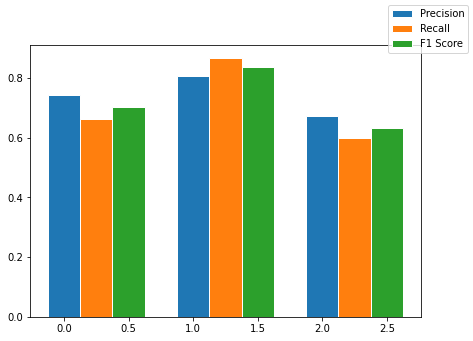

In [23]:
# Get results
report = classification_report(y_test, model.predict(X_test), output_dict=True)
neg_results = report['0']
neu_results = report['2']
pos_results = report['4']

# Set height of each bar
precisions = [results['precision'] for results in list(report.values())[:3]]
recalls = [results['recall'] for results in list(report.values())[:3]]
f1s = [results['f1-score'] for results in list(report.values())[:3]]
suports = [results['support'] for results in list(report.values())[:3]]

# Set position of bar on X axis
barWidth = 0.25
x1 = np.arange(len(precisions))
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]

# Plot the performance
fig, ax = plt.subplots(figsize=(7, 5))

# Make the plot
ax.bar(x1, precisions, width=barWidth, edgecolor='white', label='Precision')
ax.bar(x2, recalls, width=barWidth, edgecolor='white', label='Recall')
ax.bar(x3, f1s, width=barWidth, edgecolor='white', label='F1 Score')

fig.legend();
fig.show();

In [24]:
[print(x['precision']) for x in list(report.values())[:3]];

0.7437185929648241
0.8065433854907539
0.6715686274509803


In [25]:
model.classifictation_report(X_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       223
           2       0.81      0.87      0.84       654
           4       0.67      0.60      0.63       229

    accuracy                           0.77      1106
   macro avg       0.74      0.71      0.72      1106
weighted avg       0.77      0.77      0.77      1106



In [26]:
self = model

# Define the estimator tested
estimators = {SVC : 'SVC',
        MultinomialNB : 'Naive Bayes',
        SGDClassifier : 'SGD',
        KNeighborsClassifier : 'KNN',
        RandomForestClassifier : 'Random Forest',
        Perceptron : 'Perceptron',
        LogisticRegression : 'Logistic Regression'}

# Organize the estimator performance into a data frame
data = {'Estimator':[estimators[type(e['clf__estimator'])] for e in self.params],
        'score': self.means,
        'ngram_range': [e['bow__ngram_range'] for e in self.params],
        'tfidf__norm' : [e['tfidf__norm'] for e in self.params],
        'computing_time' : self.grid.cv_results_['mean_fit_time'],
        'estimator_obj' : [e['clf__estimator'] for e in self.params]}

all_results = pd.DataFrame(data=data)

# Get the best performing model for each estimator
idx = all_results.groupby(['Estimator'])['score'].transform(max) == all_results['score']
results = all_results[idx]
idx = results.groupby(['Estimator'])['computing_time'].transform(max) == results['computing_time']
results = results[idx].set_index('Estimator')
results

,score,ngram_range,tfidf__norm,computing_time,estimator_obj
Estimator,,,,,
SVC,0.755359,"(1, 2)",l2,2.906247,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
Naive Bayes,0.745706,"(1, 2)",l1,0.241333,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
SGD,0.756566,"(1, 2)",l2,0.292714,"SGDClassifier(alpha=0.0001, average=False, cla..."
KNN,0.701655,"(1, 1)",l2,0.108636,"KNeighborsClassifier(algorithm='auto', leaf_si..."
Random Forest,0.740569,"(1, 1)",l2,3.505506,"RandomForestClassifier(bootstrap=True, ccp_alp..."
Perceptron,0.707991,"(1, 2)",l1,0.285461,"Perceptron(alpha=0.0001, class_weight=None, ea..."
Logistic Regression,0.712532,"(1, 1)",l2,0.500960,"LogisticRegression(C=1.0, class_weight=None, d..."


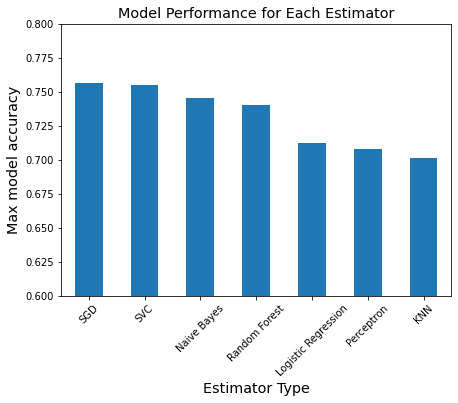

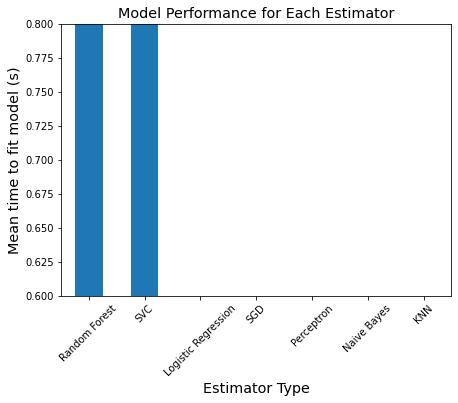

In [27]:
model.estimator_performance(ylim=(0.6, 0.8)), model.estimator_performance(metric='computing_time', ylim=(0.6, 0.8));

In [28]:
model.grid.predict_proba(['I love the world'])

array([[0., 0., 1.]])

In [29]:
model.grid.predict_proba(['I am indifferent about the world'])

array([[0.18320158, 0.74157809, 0.07522033]])

In [30]:
model.grid.predict_proba(['I hate the world'])

array([[1., 0., 0.]])

**Non-Balance results**

| | precision   | recall  |f1-score   |support|
|---|-----|-----|-----|----|
|0  |0.74 |0.66 |0.70 |223 |
|2  |0.81 |0.87 |0.84 |654 |
|4  |0.67 |0.60 |0.63 |229 |
| | | | | |
|accuracy  |||0.77 |1106 |
|macro avg   |0.74 |0.71 |0.72  |1106|
|weighted avg|0.77 |0.77 | 0.77 |1106|

# Get Test Set

Now that we have a workable model, let us scrape new, unlabeled tweets from Twitter and glean some aggregated sentiment information about various topics.

First, we will use the Twitter Developers login credentials to authenticate this program. This will allow us to fetch tweets using Twitter's API.

In [0]:
# Developer keys
consumer_key = 'WKZJjQRJBJE6ZXAy8tiBotVV0'
consumer_key_secret = 'dcy3B146XiVTYzcgYO3kqjMS3xiVfqYdUNmRAGftThsiwek36S'

# Secret token (not used anywhere)
access_token_key = '2954379412-yKnvAzEL0KTQUxZPMHQHgwTC7WNbPB7w4AOMrPO'
access_token_key_secret = '9dwQjP3WqnvIclgcnilIqTz27vdRPQgSPfOKKCA7Y4mot'

# Initialize api instance
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token_key, access_token_key_secret)
twitter_api = tweepy.API(auth)
print('Authorization successful:', twitter_api != None)

Authorization successful: True


Next, we will create a function that will gather tweets relating to a specific keyword. The function will take a keyword and the number of tweets to fetch as inputs. We will use this function later to build test sets.

In [0]:
def getTweets(search_term, num_tweets = 10000):
    fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en')
    print("Fetched {0} tweets about {1}".format(num_tweets, search_term))
    return [status.text for status in fetched_tweets]

Let's test this function to see the 10,000 most recent tweets pertaining to the search term `coronavirus`.

In [0]:
# Make query
search_term = 'coronavirus'
num_tweets = 10000

testTweets = getTweets(search_term, num_tweets)
for tweet in testTweets[:5]:
    print('\n', tweet)

Fetched 10000 tweets about coronavirus

 RT @Reuters: WATCH: As California farmers make the hard decision to plow through crops no one is buying, analysts say the drop in food supp…

 RT @cnni: Experts warn coronavirus could devastate the countries that lack healthcare equipment and infrastructure https://t.co/k3wWoeiw5l

 RT @MrDiddy85: EU on the brink: Juncker attacks Angela Merkel for causing 'permanent damage' to the bloc

Globalist infighting in the EU...…

 RT @realDonaldTrump: ....Example! V.P. Mike Pence held a conference call yesterday with all Democrat Senators. He gave them everything that…

 Coronavirus outbreak: Miami spring breakers vow to keep partying amid pa... https://t.co/tIoHskR17T via @YouTube


In [0]:
for tweet in testTweets[:5]:
    print(model.grid.predict_proba([tweet]))

[[0.19393014 0.43784576 0.3682241 ]]
[[0.09089857 0.43498879 0.47411264]]
[[0.10824294 0.77725652 0.11450055]]
[[0.52166251 0.23805604 0.24028145]]
[[0.14973683 0.63983878 0.2104244 ]]


In [0]:
(model.predict(testTweets) / 2 - 1).mean()

0.01

# (in testing. not ready to be added yet)

## Spellcheck

In [0]:
!pip install autocorrect

     |████████████████████████████████| 1.8MB 2.8MB/s 
  Created wheel for autocorrect: filename=autocorrect-1.1.0-cp36-none-any.whl size=1810772 sha256=66cd76a902f81430da5aee25848035136b2f5606bf7ca4d9e62aae13cfbb2d9e
  Stored in directory: /root/.cache/pip/wheels/78/7f/b1/527522820ae623df6a2dbe14f778d23adaea4bebe43f7ebcfe
Successfully built autocorrect


In [0]:
from autocorrect import Speller

In [0]:
spell = Speller(lang='en')
spell('trmp'), spell('hello')

('trap', 'hello')

In [0]:
!pip install symspellpy

     |████████████████████████████████| 2.6MB 2.8MB/s 


In [0]:
from symspellpy import SymSpell, Verbosity
import pkg_resources

In [0]:
sym = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [0]:
error_term = 'hellooo'
sym.lookup(error_term, Verbosity.CLOSEST, include_unknown=True)[0].term

'hello'

In [0]:
nltk.word_tokenize('hello'), nltk.word_tokenize('hellooo')

(['hello'], ['hellooo'])

## Emoji

In [0]:
!pip install emoji

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=b4155e7dc13c55f234ed89351ac838dbd02aeceeb890fda7366f1e95844eeb92
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import emoji

In [0]:
print(emoji.emojize('Python is :thumbs_up:'))

Python is 👍


In [0]:
def getTokens(text):
    stopWords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    text = text.lower()                                                 # Convert text to lower-case
    tokens = nltk.word_tokenize(text)                                   # Tokenize the text
    terms = [word for word in tokens if word not in stopWords]          # Remove tokens that are not stop words
    
    return terms

In [0]:
def getTokens(text):

    stopWords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    text = text.lower()                                                 # Convert text to lower-case
    tokens = nltk.word_tokenize(text)                                   # Tokenize the text
    terms = [word for word in tokens if (word not in stopWords and word.isalpha())]# Remove tokens that are not alphabetic or stop words
    
    return terms

In [0]:
em = emoji.emojize(':thumbs_up:')
sent = 'Python is 😀 and \ud83d but not 6'
getTokens(sent), TwitterSentimentModel.getTokens(sent)

(['python', '😀', '\ud83d', '6'], ['python'])

In [0]:
sent.translate(str.maketrans('', '', string.punctuation))

'Python is 😀 and \ud83d but not 6'

## Word Cloud

In [0]:
from wordcloud import WordCloud

In [0]:
' '.join(model.setTerms.keys())

'would rock wit yall im tight enough yet appleiphoneapps guys updates day bad nothing cool come chriswiggin french oral stereotype week wanted get striking didnt time attacked massive bee cus youre poor lonely child hahaha song forgot cheyeee yes indeed still outside ugh give thanks encouragement felt powerful quotno ones listeningquot alexalltimelow havent even seen weightless video makes sad xx ohhhhh wow missed thought mom said fault something idk aw man thats watching news loose faith human kind annasamara balcony quite high adimasty ill damned courtneyenders fuck yea amp bed ferris buellers trying go fall asleep took tylenol pm aashleyyyy know dont want faster cuz summers gone babyjew sorry force habit amazcuna went uniqlo expensive hk clothdiapermom oh hope okay quotthe perks wallflowerquot favourite book ever antkatie wish work sleepy chucklebug nice mall lucky tweetin makin feel left amyyvee byee cya tomoz coachdeb miss quotreallyquot reading since got attached computer listen 

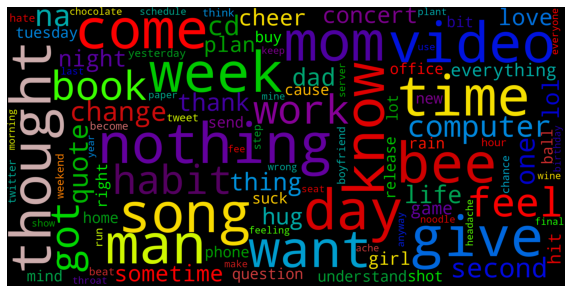

In [0]:
def word_cloud(tweets):
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                           background_color="black", max_words=100,
                           contour_width=1, contour_color="steelblue", 
                           colormap="nipy_spectral").generate(tweets)

    #Now we plot the figure
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()  

word_cloud(' '.join(model.setTerms.keys()))

## Sentiment140 (deprecated)

We will use the [Sentiment140](https://www.kaggle.com/kazanova/sentiment140) dataset from kaggle. This set contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 1 = positive) and they can be used to detect sentiment .

The official link regarding the dataset with resources about how it was generated can be found [here](http://%20http//help.sentiment140.com/for-students/).

The official paper detailing the approach can be found [here](http://bhttp//cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf).

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [0]:
sentiment140 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MATH 637/Final Project/twitter_training_data.csv', header=None, encoding='latin-1')[::100]
sentiment140.columns = ["target", "tweet_ids", "date", "flag", "user", "text"]
sentiment140.target = (sentiment140.target > 0).astype(int)
sentiment140.head()

,target,tweet_ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
100,0,1467836873,Mon Apr 06 22:26:33 PDT 2009,NO_QUERY,LeakySpoon,Body Of Missing Northern Calif. Girl Found: P...
200,0,1467861522,Mon Apr 06 22:33:00 PDT 2009,NO_QUERY,bovinemammal,"Job Interview in Cardiff today, wish me luck! ..."
300,0,1467890079,Mon Apr 06 22:40:38 PDT 2009,NO_QUERY,BATMANNN,@jokerrrr It stillllll hasn't arrived
400,0,1467913111,Mon Apr 06 22:46:57 PDT 2009,NO_QUERY,nssmom,#3 woke up and was having an accident - &quot;...


In [0]:
trainData = [{'label':target, 'text':text} for target, text in zip(sentiment140.target, sentiment140.text)]

print('Negative Tweets')
for tweet in trainData[:5]:
    print(tweet['label'], tweet['text'])

print('\nPositive Tweets')
for tweet in trainData[-5:]:
    print(tweet['label'], tweet['text'])

Negative Tweets
0 @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
0  Body Of Missing Northern Calif. Girl Found: Police have found the remains of a missing Northern California girl .. http://tr.im/imji
0 Job Interview in Cardiff today, wish me luck! Got about 3 hours sleep 
0 @jokerrrr It stillllll hasn't arrived 
0 #3 woke up and was having an accident - &quot;It's pushing, it's pushing!&quot; he was crying because he couldn't stop from wetting his pants.  

Positive Tweets
1 Sitting in a meeting with my mom &amp; grandmother reguarding the school. Hopefully opening more locations &amp; salon/spas.. Yay!! 
1 @Elle_333 @jenfafer midnight showing peoples, y'all better be with me 
1 @sthrnfairytale Any Tips for training Rach?? 
1 @cherub_rock123 ehh....it's a day. 
1 @cris1015 My goal on stocks like $MTXX is to help, if just one person avoided this stock on my post, would make the keystrokes worth it.  


In [0]:
X_train, X_test, y_train, y_test = train_test_split(sentiment140.text, sentiment140.target, test_size=0.33, random_state=637)

print('Positive Tweets')
for tweet in X_train[y_train == 1].values[-5:]:
    print(tweet)

print('\nNegative Tweets')
for tweet in X_train[y_train == 0].values[-5:]:
    print(tweet)

Positive Tweets
@permeister filled out the form. Thanks mucho!  You rock!!! 
@sgaw good choice, sometimes having a rest is the best thing to do! 
@KrisAllenmusic Wow! Hi Kris!Hope you get to tour in the Phils! 
@Seamonkey86 I hope they are  and I have FIVE 5 5ive five fIvE FiVe left...can you tell that Im excited? haha
@craigfots mmmmm. who knows?? from memory I'd say the beer and sunshine may be a deal breaker 

Negative Tweets
@mpeleides i didnt see your @ last night! obv, i wasnt at the party today  i wanted so badly to go but i couldnt walk!
@Juniesgurl Ugh... I'm sorry  I'm good thanks! I could sleep all day but I won't. LOL!
@jash001 but i need about another 200 pages  and i'm sniggering away, oh how I laugh...ha ha ha! ;)
Another hour of pain done. My heart has been in the wrong place for awhile. Another hour coming with pantera. I need this I have slacked 
is wondering who would be so cruel as to cut off her cat's whiskers 


# References

[SymSpell](https://towardsdatascience.com/essential-text-correction-process-for-nlp-tasks-f731a025fcc3)

[Big main one](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)

[Search tweets](https://blog.goodaudience.com/using-the-twitter-api-with-python-c6e8da96d273)

[analysis.sentiment.polarity](https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/)

[Textblob documentation](https://textblob.readthedocs.io/en/dev/api_reference.html)

[datasets (categories)](https://lionbridge.ai/datasets/top-20-twitter-datasets-for-natural-language-processing-and-machine-learning/)

[new train data1](https://github.com/TharinduMunasinge/Twitter-Sentiment-Analysis/blob/master/DataSet/FinalizedFull.csv)

documentations about [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

stack overflow for [clfswitcher](https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers)

Literature:

 * [https://en.wikipedia.org/wiki/Inter-rater_reliability](https://en.wikipedia.org/wiki/Inter-rater_reliability)
 * [best model not so good](https://en.wikipedia.org/wiki/Inter-rater_reliability)
 * [what a good score it](https://www.quora.com/What-is-the-accepted-accuracy-of-sentiment-analysis)
 * [github repo](https://github.com/ayushoriginal/Sentiment-Analysis-Twitter) with report-style format
